## Linear Model and Linear Model with One Hidden Layer

In [1]:
import torch
from torch import nn
from torch.optim import SGD, Adam
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split

from typing import Tuple, Union, List, Callable
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
#From Transfer Learning Tutorial
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])
    dataset = torchvision.datasets.ImageFolder('/kaggle/input/birds23sp/birds/train', transform=transform_train)
    print([int(0.6 * len(dataset)), int( 0.1 * len(dataset)), int( 0.3 * len(dataset))])
    print(len(dataset))
    train_dataset, val_dataset, test_dataset = random_split(dataset, [int(0.6 * len(dataset)), int( 0.1 * len(dataset)), int( 0.3 * len(dataset) + 1)])
    #train_dataset, val_dataset = random_split(train_dataset, [int(0.9 * len(train_dataset)), int( 0.1 * len(train_dataset))])
    
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=2)
    
    train_sub_dataset = torch.utils.data.Subset(train_dataset, range(4500))
    train_dataset_search, val_dataset_search = random_split(train_sub_dataset, [int(0.9 * len(train_sub_dataset)), int( 0.1 * len(train_sub_dataset))])

    # Create separate dataloaders for the train, test, and validation set
    train_loader_search = DataLoader(
        train_dataset_search,
        batch_size=128,
        shuffle=True
    )

    val_loader_search = DataLoader(
        val_dataset_search,
        batch_size=128,
        shuffle=True
    )

    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
    classes = open('/kaggle/input/birds23sp/birds/names.txt').read().strip().split("\n")
    class_to_idx = dataset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    print(len(idx_to_class))
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'val': valloader, 'test': testloader, 'train_search': train_loader_search, 'val_search': val_loader_search, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

[23137, 3856, 11568]
38562
555


In [4]:
# Train function modeled from CSE 446 PyTorch tutorial
batch_size = 128
def train(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20
)-> Tuple[List[float], List[float], List[float], List[float]]:

    loss = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for e in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for (x_batch, labels) in train_loader:
            x_batch, labels = x_batch.to(device), labels.to(device)
            optimizer.zero_grad()
            labels_pred = model(x_batch)
            batch_loss = loss(labels_pred, labels)
            train_loss = train_loss + batch_loss.item()

            labels_pred_max = torch.argmax(labels_pred, 1)
            batch_acc = torch.sum(labels_pred_max == labels)
            train_acc = train_acc + batch_acc.item()

            batch_loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / (batch_size * len(train_loader)))

        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for (v_batch, labels) in val_loader:
                v_batch, labels = v_batch.to(device), labels.to(device)
                labels_pred = model(v_batch)
                v_batch_loss = loss(labels_pred, labels)
                val_loss = val_loss + v_batch_loss.item()

                v_pred_max = torch.argmax(labels_pred, 1)
                batch_acc = torch.sum(v_pred_max == labels)
                val_acc = val_acc + batch_acc.item()
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_acc / (batch_size * len(val_loader)))

    return train_losses, train_accuracies, val_losses, val_accuracies

In [9]:
# Checking sizing
imgs, labels = next(iter(data['train']))
example_image = imgs[0]
d = example_image.flatten().size()[0]
print(example_image.shape)
print(d)
print(imgs.shape)

torch.Size([3, 128, 128])
49152
torch.Size([128, 3, 128, 128])


In [21]:
# Basic Linear Model
def linear_model() -> nn.Module:
    model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d, 555)
            )
    return model.to(device)

In [22]:
lin_model = linear_model()
lin_optimizer = SGD(lin_model.parameters(), 0.1)

In [ ]:
train_loss = test_train(lin_model, data['train'])

In [32]:
train_loss, train_accuracy, val_loss, val_accuracy = train(
    lin_model, lin_optimizer, data['train'], data['val'], 20
)

  0%|          | 0/20 [00:00<?, ?it/s]

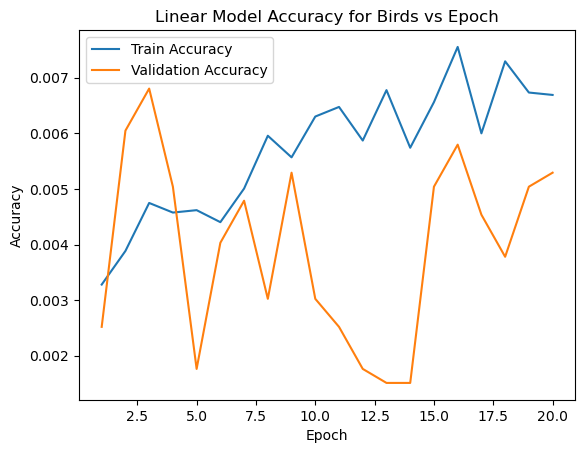

In [33]:
epochs = range(1, 21)
plt.plot(epochs, train_accuracy, label="Train Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Linear Model Accuracy for Birds vs Epoch")
plt.show()

In [10]:
# Linear Model with a single hidden layer and ReLU activation function
def linear_hid_model(hid) -> nn.Module:
    model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d, hid),
            nn.ReLU(),
            nn.Linear(hid, 555)
            )
    return model.to(device)

In [38]:
lin_hid_model = linear_hid_model(800)
lin_hid_optimizer = SGD(lin_hid_model.parameters(), 0.1)

In [39]:
train_loss, train_accuracy, val_loss, val_accuracy = train(
    lin_hid_model, lin_hid_optimizer, data['train'], data['val'], 20
)

  0%|          | 0/20 [00:00<?, ?it/s]

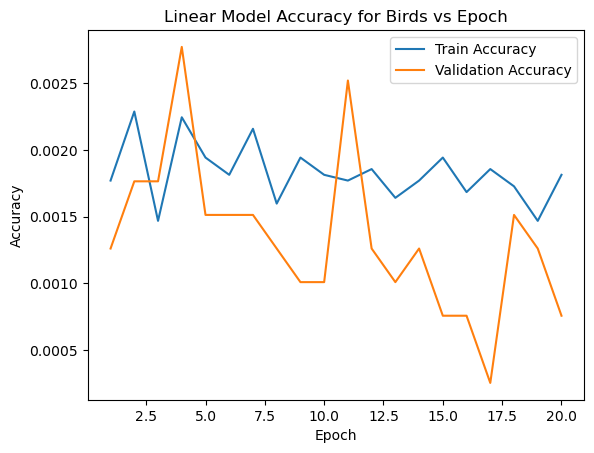

In [44]:
epochs = range(1, 21)
plt.plot(epochs, train_accuracy, label="Train Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Linear Model Accuracy for Birds vs Epoch")
plt.show()

In [5]:
# Hyperparameter search function applied to Linear Model with single hidden layer to compare performance
# Modeled from CSE 446 PyTorch tutorial
def parameter_search_one_hid(
    train_loader: DataLoader, 
    val_loader: DataLoader, 
    model_fn:Callable[[], nn.Module]
) -> Tuple[float, int, float]:
    
    num_iter = 20 
    best_loss = torch.tensor(np.inf)
    best_lr = 0.0
    best_M = 0
    best_mu = 0.0

    for i in range(num_iter):
        lr = 10**np.random.uniform(-5, -1)
        M = np.random.randint(600, 1500)
        mu = np.random.uniform(0, 1)
        print(f"trying learning rate {lr}")
        print(f"trying M {M}")
        print(f"trying momentum {mu}")
        model = model_fn(M)
        optim = SGD(model.parameters(), lr, mu)
        
        train_loss_search, train_acc_search, val_loss_search, val_acc_search = train(
            model,
            optim,
            train_loader,
            val_loader,
            epochs=3
            )

        if min(val_loss_search) < best_loss:
            best_loss = min(val_loss_search)
            best_lr = lr
            best_M = M
            best_mu = mu
        
    return best_lr, best_M, best_mu

In [11]:
# Hyperparameter tuning for Linear model with one hidden layer
best_lr_hid, best_M_hid, best_mu_hid = parameter_search_one_hid(data['train_search'], data['val_search'], linear_hid_model)

trying learning rate 0.00039922143629399226
trying M 1094
trying momentum 0.039162825699596726


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.010205964877071741
trying M 656
trying momentum 0.30757909261622896


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 2.4142100591903554e-05
trying M 1245
trying momentum 0.6732672516705313


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.0004963850864754039
trying M 789
trying momentum 0.4983333088126731


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 1.3499159045548069e-05
trying M 1049
trying momentum 0.047632110535411054


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.010016283321238977
trying M 1220
trying momentum 0.835742964292433


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.003969600199200712
trying M 606
trying momentum 0.5218454108156432


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 3.1112826124467184e-05
trying M 731
trying momentum 0.9422303242079793


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.0019702279653258307
trying M 854
trying momentum 0.9844709038610998


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 1.9385392118533927e-05
trying M 1037
trying momentum 0.05599491284616176


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.0042609963289821015
trying M 936
trying momentum 0.2361062955714247


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.030102589986881565
trying M 775
trying momentum 0.22777937725742092


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.005608937515882631
trying M 1330
trying momentum 0.7104106492712066


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.054491564909737576
trying M 1429
trying momentum 0.6902574766986048


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 3.6461477926005055e-05
trying M 1265
trying momentum 0.8610753196416726


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.003777380290161575
trying M 740
trying momentum 0.9414125852702327


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 1.592159630325542e-05
trying M 746
trying momentum 0.6854132171475225


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.00024377043865357237
trying M 1126
trying momentum 0.7088232581421352


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.04121369002292908
trying M 1446
trying momentum 0.7967869365825014


  0%|          | 0/3 [00:00<?, ?it/s]

trying learning rate 0.002469930397087398
trying M 1217
trying momentum 0.7795040835254172


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
lin_hid_model_searched = linear_hid_model(best_M_hid)
lin_hid_optimizer_searched = SGD(lin_hid_model_searched.parameters(), best_lr_hid, best_mu_hid)

In [13]:
train_loss_hid_searched, train_accuracy_hid_searched, val_loss_hid_searched, val_accuracy_hid_searched = train(
    lin_hid_model_searched, lin_hid_optimizer_searched, data['train'], data['val'], 20
)

  0%|          | 0/20 [00:00<?, ?it/s]

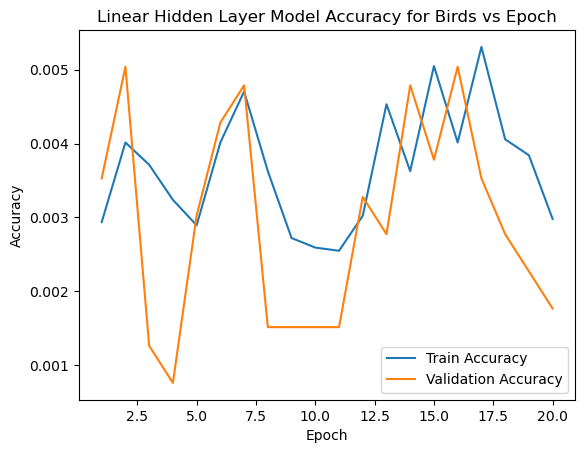

In [15]:
epochs = range(1, 21)
plt.plot(epochs, train_accuracy_hid_searched, label="Train Accuracy")
plt.plot(epochs, val_accuracy_hid_searched, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Linear Hidden Layer Model Accuracy for Birds vs Epoch")
plt.show()

In [18]:
# Test data accuracy function modeled from CSE 446 PyTorch tutorial
def evaluate(
    model: nn.Module, loader: DataLoader
) -> Tuple[float, float]:
    """Computes test loss and accuracy of model on loader."""
    loss = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for (batch, labels) in loader:
            batch, labels = batch.to(device), labels.to(device)
            y_batch_pred = model(batch)
            batch_loss = loss(y_batch_pred, labels)
            test_loss = test_loss + batch_loss.item()

            pred_max = torch.argmax(y_batch_pred, 1)
            batch_acc = torch.sum(pred_max == labels)
            test_acc = test_acc + batch_acc.item()
        test_loss = test_loss / len(loader)
        test_acc = test_acc / (len(loader))
        return test_loss, test_acc

In [19]:
# Accuracy of Linear model with one hidden layer on test set
test_loss, test_acc = evaluate(lin_hid_model_searched, data['test'])
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.002420261042441006
